In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Definición de la arquitectura de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 64)    # Capa de entrada con 256 neuronas
        self.fc2 = nn.Linear(64, 64)  # Capa oculta 1
        self.fc3 = nn.Linear(64, 64)  # Capa oculta 2
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)  # Capa oculta 3
        self.fc6 = nn.Linear(64, 1)    # Capa de salida
        self.activation = nn.LogSigmoid()  # Función de activación

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.fc6(x)
        return x

# Parámetros de la simulación
R_max = 30          # Intervalo de Radio
r_initial = 10      # Condición inicial en r = 10
r_boundary = R_max  # Condición de frontera en r = 30
M = 2               # Valor de la masa

# Generar datos exactos a partir de las soluciones analíticas
def generate_data(r):
    g_tt_exact = -(1 - 2 * M / r)
    g_rr_exact = 1 / (1 - 2 * M / r)
    return g_tt_exact, g_rr_exact

# Condiciones iniciales y de frontera
g_tt_initial = torch.tensor([[-0.6]], dtype=torch.float32)
g_rr_initial = torch.tensor([[1.7]], dtype=torch.float32)
g_tt_boundary = torch.tensor([[-0.87]], dtype=torch.float32)
g_rr_boundary = torch.tensor([[1.15]], dtype=torch.float32)

# Definir las redes neuronales
net0 = PINN()  # Red para g_tt
net1 = PINN()  # Red para g_rr

# Definir los optimizadores
optimizer0 = optim.Adam(net0.parameters(), lr=1e-3)
optimizer1 = optim.Adam(net1.parameters(), lr=1e-3)

# Pérdida física basada en las ecuaciones de Ricci
def calculate_physics_loss(r, g_tt, g_rr):
    eps = 1e-8  # Pequeña constante para evitar divisiones por cero
    g_00_mod = (g_tt / r**2) + 2 * M / r - 1 
    g_11_r = -1/g_00_mod#torch.autograd.grad(g_rr, r, torch.ones_like(g_rr), create_graph=True)[0]
    g_00_r = torch.autograd.grad(g_00_mod, r, torch.ones_like(g_00_mod), create_graph=True)[0]

    A = -2/r * (g_00_r / (g_rr + eps)) - (g_00_r / (r * (g_00_mod + eps))) - (g_11_r / (r * (g_rr + eps)))
    B = 1 - (1 / (g_00_mod + eps)) - (r * g_11_r) / (2 * (g_rr**2 + eps)) + (r * g_00_r) / (2 * (g_00_mod * g_rr + eps))
    reduced = r*g_00_r + g_00_mod + 1
    phys_residual = reduced
    phys_loss = nn.MSELoss()(phys_residual, torch.zeros_like(phys_residual))
    return phys_loss

# Función de pérdida que incluye las condiciones iniciales y de frontera
def loss_fn(r, g_tt, g_rr, net0, net1, data_r, g_tt_data, g_rr_data):
    # Pérdida física
    phys_loss = calculate_physics_loss(r, g_tt, g_rr)
    
    # Evaluar en los puntos de las condiciones iniciales y de frontera
    r_initial_tensor = torch.tensor([[r_initial]], dtype=torch.float32, requires_grad=True)
    r_boundary_tensor = torch.tensor([[r_boundary]], dtype=torch.float32, requires_grad=True)
    
    # Condiciones iniciales
    g_tt_pred_initial = net0(r_initial_tensor)
    g_rr_pred_initial = net1(r_initial_tensor)
    initial_loss = nn.MSELoss()(g_tt_pred_initial, g_tt_initial) + nn.MSELoss()(g_rr_pred_initial, g_rr_initial)
    
    # Condiciones de frontera
    g_tt_pred_boundary = net0(r_boundary_tensor)
    g_rr_pred_boundary = net1(r_boundary_tensor)
    boundary_loss = nn.MSELoss()(g_tt_pred_boundary, g_tt_boundary) + nn.MSELoss()(g_rr_pred_boundary, g_rr_boundary)
    
    # Pérdida supervisada con datos exactos
    g_tt_pred_data = net0(data_r)
    g_rr_pred_data = net1(data_r)
    data_loss = nn.MSELoss()(g_tt_pred_data, g_tt_data) + nn.MSELoss()(g_rr_pred_data, g_rr_data)
    
    # Sumar todas las pérdidas
    total_loss = phys_loss + initial_loss + boundary_loss + data_loss
    return total_loss

# Función para graficar las predicciones y las soluciones analíticas
def plot_predictions(R, g_tt_pred, g_rr_pred, epoch):
    r_vals = R.detach().numpy()  # Convertir los valores de r a numpy

    # Soluciones analíticas
    g_tt_exact = -(1 - 2 * M / r_vals)  # Solución exacta de g_00
    g_rr_exact = 1 / (1 - 2 * M / r_vals)  # Solución exacta de g_11

    plt.figure(figsize=(12, 5))

    # Gráfico de g_tt
    plt.subplot(1, 2, 1)
    plt.plot(r_vals, g_tt_pred.detach().numpy(), label='$g_{00}$ - PINN', color='blue')
    plt.plot(r_vals, g_tt_exact, label='$g_{00}$ - Exacta', color='orange', linestyle='--')
    plt.title('Predicción de $g_{00}$' f' en época {epoch}')
    plt.xlabel('r')
    plt.ylabel('$g_{00}$')
    plt.legend()
    plt.savefig(f'g00-{epoch}.png')

    # Gráfico de g_rr
    plt.subplot(1, 2, 2)
    plt.plot(r_vals, g_rr_pred.detach().numpy(), label='$g_{11}$ - PINN', color='green')
    plt.plot(r_vals, g_rr_exact, label='$g_{11}$ - Exacta', color='red', linestyle='--')
    plt.title('Predicción de $g_{11}$' f' en época {epoch}')
    plt.xlabel('r')
    plt.ylabel('$g_{11}$')
    plt.legend()
    plt.savefig(f'g11-{epoch}.png')

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()

# Función para graficar la función de pérdida
def plot_loss(loss_history):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label='Loss', color='red')
    plt.title('Evolución de la función de pérdida')
    plt.yscale('log')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

# Crear una lista para almacenar la pérdida en cada época
loss_history = []

# Generar datos sintéticos
R = torch.linspace(r_initial, r_boundary, 10000).view(-1, 1).float().requires_grad_(True)  # Valores de r en el intervalo con grad
g_tt_data, g_rr_data = generate_data(R.detach().numpy())  # Generar datos exactos
g_tt_data = torch.tensor(g_tt_data, dtype=torch.float32).view(-1, 1)
g_rr_data = torch.tensor(g_rr_data, dtype=torch.float32).view(-1, 1)

# Entrenamiento de la red neuronal
num_epochs = 401
plot_interval = 100  # Intervalo de épocas para graficar

for epoch in range(num_epochs):
    optimizer1.zero_grad()
    optimizer0.zero_grad()

    # Calcular la predicción de la PINN en el dominio
    g_tt = net0(R)
    g_rr = net1(R)

    # Calcular la pérdida total
    loss = loss_fn(R, g_tt, g_rr, net0, net1, R, g_tt_data, g_rr_data)
    
    # Backpropagation
    loss.backward()
    
    # Optimización
    optimizer0.step()
    optimizer1.step()

    # Guardar la pérdida en la lista
    loss_history.append(loss.item())

    if epoch % plot_interval == 0:
        print(f'Época {epoch}, Costo: {loss.item()}')
        # Graficar las predicciones
        plot_predictions(R, g_tt, g_rr, epoch)
        

# Graficar la evolución de la pérdida
plot_loss(loss_history)
plt.savefig('loss.png')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Definición de la arquitectura de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 256)    # Capa de entrada con 256 neuronas
        self.fc2 = nn.Linear(256, 256)  # Capa oculta 1
        self.fc3 = nn.Linear(256, 256)  # Capa oculta 2
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)  # Capa oculta 3
        self.fc6 = nn.Linear(256, 1)    # Capa de salida
        self.activation = nn.LogSigmoid()  # Función de activación

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.fc6(x)
        return x

# Parámetros de la simulación
R_max = 30          # Intervalo de Radio
r_initial = 10      # Condición inicial en r = 10
r_boundary = R_max  # Condición de frontera en r = 30
M = 2               # Valor de la masa

# Generar datos exactos a partir de las soluciones analíticas
def generate_data(r):
    g_tt_exact = -(1 - 2 * M / r)
    g_rr_exact = 1 / (1 - 2 * M / r)
    return g_tt_exact, g_rr_exact

# Condiciones iniciales y de frontera
g_tt_initial = torch.tensor([[-0.6]], dtype=torch.float32)
g_rr_initial = torch.tensor([[1.7]], dtype=torch.float32)
g_tt_boundary = torch.tensor([[-0.87]], dtype=torch.float32)
g_rr_boundary = torch.tensor([[1.15]], dtype=torch.float32)

# Definir las redes neuronales
net0 = PINN()  # Red para g_tt
net1 = PINN()  # Red para g_rr

# Definir los optimizadores
optimizer0 = optim.Adam(net0.parameters(), lr=1e-3)
optimizer1 = optim.Adam(net1.parameters(), lr=1e-3)

# Pérdida física basada en las ecuaciones de Ricci
def calculate_physics_loss(r, g_tt, g_rr):
    eps = 1e-8  # Pequeña constante para evitar divisiones por cero
    g_00_mod = (g_tt / r**2) + 2 * M / r - 1 
    g_11_r = -1/g_00_mod#torch.autograd.grad(g_rr, r, torch.ones_like(g_rr), create_graph=True)[0]
    g_00_r = torch.autograd.grad(g_00_mod, r, torch.ones_like(g_00_mod), create_graph=True)[0]

    A = -2/r * (g_00_r / (g_rr + eps)) - (g_00_r / (r * (g_00_mod + eps))) - (g_11_r / (r * (g_rr + eps)))
    B = 1 - (1 / (g_00_mod + eps)) - (r * g_11_r) / (2 * (g_rr**2 + eps)) + (r * g_00_r) / (2 * (g_00_mod * g_rr + eps))
    reduced = r*g_00_r + g_00_mod + 1
    phys_residual = reduced
    phys_loss = nn.MSELoss()(phys_residual, torch.zeros_like(phys_residual))
    return phys_loss

# Función de pérdida que incluye las condiciones iniciales y de frontera
def loss_fn(r, g_tt, g_rr, net0, net1, data_r, g_tt_data, g_rr_data):
    # Pérdida física
    phys_loss = calculate_physics_loss(r, g_tt, g_rr)
    
    # Evaluar en los puntos de las condiciones iniciales y de frontera
    r_initial_tensor = torch.tensor([[r_initial]], dtype=torch.float32, requires_grad=True)
    r_boundary_tensor = torch.tensor([[r_boundary]], dtype=torch.float32, requires_grad=True)
    
    # Condiciones iniciales
    g_tt_pred_initial = net0(r_initial_tensor)
    g_rr_pred_initial = net1(r_initial_tensor)
    initial_loss = nn.MSELoss()(g_tt_pred_initial, g_tt_initial) + nn.MSELoss()(g_rr_pred_initial, g_rr_initial)
    
    # Condiciones de frontera
    g_tt_pred_boundary = net0(r_boundary_tensor)
    g_rr_pred_boundary = net1(r_boundary_tensor)
    boundary_loss = nn.MSELoss()(g_tt_pred_boundary, g_tt_boundary) + nn.MSELoss()(g_rr_pred_boundary, g_rr_boundary)
    
    # Pérdida supervisada con datos exactos
    g_tt_pred_data = net0(data_r)
    g_rr_pred_data = net1(data_r)
    data_loss = nn.MSELoss()(g_tt_pred_data, g_tt_data) + nn.MSELoss()(g_rr_pred_data, g_rr_data)
    
    # Sumar todas las pérdidas
    total_loss = phys_loss + initial_loss + boundary_loss + data_loss
    return total_loss

# Función para graficar las predicciones y las soluciones analíticas para múltiples épocas
def plot_predictions_multi(R, g_tt_preds, g_rr_preds, epochs):
    r_vals = R.detach().numpy()  # Convertir los valores de r a numpy

    # Soluciones analíticas
    R = torch.linspace(r_initial, r_boundary, 10000).view(-1, 1).float().requires_grad_(True)  # Valores de r en el intervalo con grad
    g_tt_exact = -(1 - 2 * M / r_vals)  # Solución exacta de g_00
    g_rr_exact = 1 / (1 - 2 * M / r_vals)  # Solución exacta de g_11

    plt.figure(figsize=(12, 5))

    # Gráfico de g_tt
    plt.subplot(1, 2, 1)
    plt.plot(r_vals, g_tt_exact, label='$g_{00}$ - Exacta', color='black', linestyle='--')
    for g_tt_pred, epoch in zip(g_tt_preds, epochs):
        plt.plot(r_vals, g_tt_pred.detach().numpy(), label=f'$g_{{00}}$ - PINN Época {epoch}')
    plt.title('Predicción de $g_{00}$ para múltiples épocas')
    plt.xlabel('r')
    plt.ylabel('$g_{00}$')
    plt.legend()

    # Gráfico de g_rr
    plt.subplot(1, 2, 2)
    plt.plot(r_vals, g_rr_exact, label='$g_{11}$ - Exacta', color='black', linestyle='--')
    for g_rr_pred, epoch in zip(g_rr_preds, epochs):
        plt.plot(r_vals, g_rr_pred.detach().numpy(), label=f'$g_{{11}}$ - PINN Época {epoch}')
    plt.title('Predicción de $g_{11}$ para múltiples épocas')
    plt.xlabel('r')
    plt.ylabel('$g_{11}$')
    plt.legend()

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()

# Entrenamiento de la red neuronal
num_epochs = 401
plot_interval = 100  # Intervalo de épocas para graficar

# Variables para almacenar las predicciones en las épocas 10, 100, y 400
predictions_g_tt = []
predictions_g_rr = []
epochs_to_plot = [50, 100, 200, 400]

for epoch in range(num_epochs):
    optimizer1.zero_grad()
    optimizer0.zero_grad()

    # Calcular la predicción de la PINN en el dominio
    g_tt = net0(R)
    g_rr = net1(R)

    # Calcular la pérdida total
    loss = loss_fn(R, g_tt, g_rr, net0, net1, R, g_tt_data, g_rr_data)
    
    # Backpropagation
    loss.backward()
    
    # Optimización
    optimizer0.step()
    optimizer1.step()

    # Guardar la pérdida en la lista
    loss_history.append(loss.item())

    # Almacenar predicciones en las épocas 10, 100, y 400
    if epoch in epochs_to_plot:
        predictions_g_tt.append(g_tt.clone())  # Clonar las predicciones para almacenarlas
        predictions_g_rr.append(g_rr.clone())

    if epoch % plot_interval == 0:
        print(f'Época {epoch}, Costo: {loss.item()}')

# Graficar las predicciones en las épocas seleccionadas
plot_predictions_multi(R, predictions_g_tt, predictions_g_rr, epochs_to_plot)

# Graficar la evolución de la pérdida
plot_loss(loss_history)
plt.savefig('loss.png')


Época 0, Costo: 2.205277681350708
Época 200, Costo: 0.00017247321375180036
Época 400, Costo: 5.518772923096549e-06


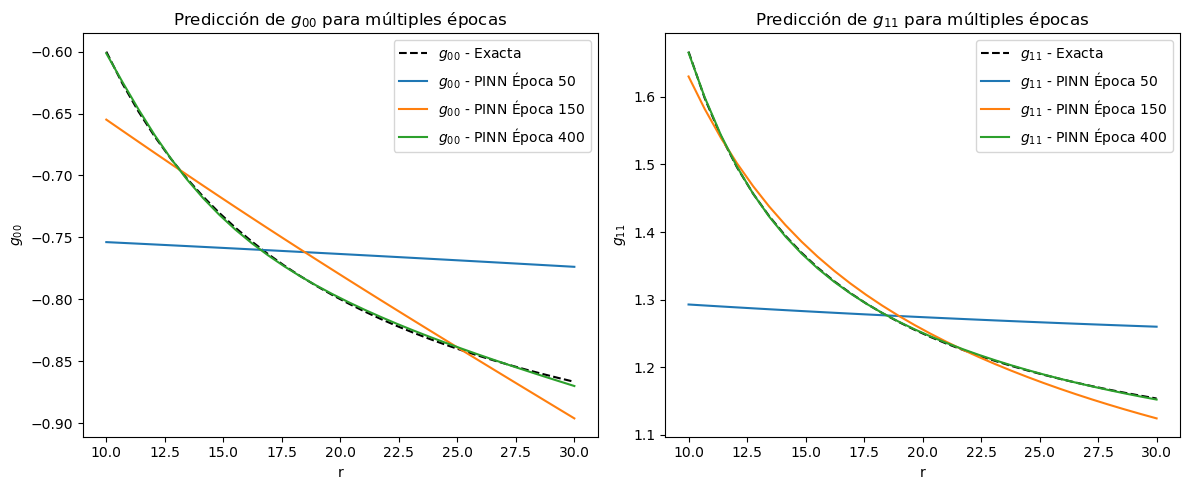

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Definición de la arquitectura de la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 64)    # Capa de entrada con 256 neuronas
        self.fc2 = nn.Linear(64, 64)  # Capa oculta 1
        self.fc3 = nn.Linear(64, 64)  # Capa oculta 2
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)  # Capa oculta 3
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 1)    # Capa de salida
        self.activation = nn.LogSigmoid()  # Función de activación

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))
        x = self.fc7(x)
        return x

# Parámetros de la simulación
R_max = 30          # Intervalo de Radio
r_initial = 10      # Condición inicial en r = 10
r_boundary = R_max  # Condición de frontera en r = 30
M = 2               # Valor de la masa

# Generar datos exactos a partir de las soluciones analíticas
def generate_data(r):
    g_tt_exact = -(1 - 2 * M / r)
    g_rr_exact = 1 / (1 - 2 * M / r)
    return g_tt_exact, g_rr_exact

# Condiciones iniciales y de frontera
g_tt_initial = torch.tensor([[-0.6]], dtype=torch.float32)
g_rr_initial = torch.tensor([[1.7]], dtype=torch.float32)
g_tt_boundary = torch.tensor([[-0.87]], dtype=torch.float32)
g_rr_boundary = torch.tensor([[1.15]], dtype=torch.float32)

# Definir las redes neuronales
net0 = PINN()  # Red para g_tt
net1 = PINN()  # Red para g_rr

# Definir los optimizadores
optimizer0 = optim.Adam(net0.parameters(), lr=1e-3)
optimizer1 = optim.Adam(net1.parameters(), lr=1e-3)
# Añadir schedulers para reducir el learning rate
scheduler0 = lr_scheduler.ReduceLROnPlateau(
    optimizer0, 
    mode='min',  # Reducir LR cuando la métrica deja de mejorar
    factor=0.5,  # Reducir a la mitad
    patience=50,  # Tolerar 50 épocas sin mejora
    verbose=True  # Mostrar mensaje cuando se reduce el LR
)
scheduler1 = lr_scheduler.ReduceLROnPlateau(
    optimizer1, 
    mode='min', 
    factor=0.5, 
    patience=50, 
    verbose=True
)
# Pérdida física basada en las ecuaciones de Ricci
def calculate_physics_loss(r, g_tt, g_rr):
    eps = 1e-8  # Pequeña constante para evitar divisiones por cero
    g_00_mod = (g_tt / r**2) + 2 * M / r - 1 
    g_11_r = -1/g_00_mod
    g_00_r = torch.autograd.grad(g_00_mod, r, torch.ones_like(g_00_mod), create_graph=True)[0]

    reduced = r * g_00_r + g_00_mod + 1
    phys_residual = reduced
    phys_loss = nn.MSELoss()(phys_residual, torch.zeros_like(phys_residual))
    return phys_loss

# Función de pérdida que incluye las condiciones iniciales y de frontera
def loss_fn(r, g_tt, g_rr, net0, net1, data_r, g_tt_data, g_rr_data):
    # Pérdida física
    phys_loss = calculate_physics_loss(r, g_tt, g_rr)
    
    # Evaluar en los puntos de las condiciones iniciales y de frontera
    r_initial_tensor = torch.tensor([[r_initial]], dtype=torch.float32, requires_grad=True)
    r_boundary_tensor = torch.tensor([[r_boundary]], dtype=torch.float32, requires_grad=True)
    
    # Condiciones iniciales
    g_tt_pred_initial = net0(r_initial_tensor)
    g_rr_pred_initial = net1(r_initial_tensor)
    initial_loss = nn.MSELoss()(g_tt_pred_initial, g_tt_initial) + nn.MSELoss()(g_rr_pred_initial, g_rr_initial)
    
    # Condiciones de frontera
    g_tt_pred_boundary = net0(r_boundary_tensor)
    g_rr_pred_boundary = net1(r_boundary_tensor)
    boundary_loss = nn.MSELoss()(g_tt_pred_boundary, g_tt_boundary) + nn.MSELoss()(g_rr_pred_boundary, g_rr_boundary)
    
    # Pérdida supervisada con datos exactos
    g_tt_pred_data = net0(data_r)
    g_rr_pred_data = net1(data_r)
    data_loss = nn.MSELoss()(g_tt_pred_data, g_tt_data) + nn.MSELoss()(g_rr_pred_data, g_rr_data)
    
    # Sumar todas las pérdidas
    total_loss = phys_loss + data_loss#+ initial_loss + boundary_loss 
    return total_loss

# Función para graficar las predicciones y las soluciones analíticas para múltiples épocas
def plot_predictions_multi(R, g_tt_preds, g_rr_preds, epochs):
    r_vals = R.detach().numpy()  # Convertir los valores de r a numpy

    # Soluciones analíticas
    g_tt_exact = -(1 - 2 * M / r_vals)  # Solución exacta de g_00
    g_rr_exact = 1 / (1 - 2 * M / r_vals)  # Solución exacta de g_11

    plt.figure(figsize=(12, 5))

    # Gráfico de g_tt
    plt.subplot(1, 2, 1)
    plt.plot(r_vals, g_tt_exact, label='$g_{00}$ - Exacta', color='black', linestyle='--')
    for g_tt_pred, epoch in zip(g_tt_preds, epochs):
        plt.plot(r_vals, g_tt_pred.detach().numpy(), label=f'$g_{{00}}$ - PINN Época {epoch}')
    plt.title('Predicción de $g_{00}$ para múltiples épocas')
    plt.xlabel('r')
    plt.ylabel('$g_{00}$')
    plt.legend()
    #plt.savefig('g00-ev-uni.png')

    # Gráfico de g_rr
    plt.subplot(1, 2, 2)
    plt.plot(r_vals, g_rr_exact, label='$g_{11}$ - Exacta', color='black', linestyle='--')
    for g_rr_pred, epoch in zip(g_rr_preds, epochs):
        plt.plot(r_vals, g_rr_pred.detach().numpy(), label=f'$g_{{11}}$ - PINN Época {epoch}')
    plt.title('Predicción de $g_{11}$ para múltiples épocas')
    plt.xlabel('r')
    plt.ylabel('$g_{11}$')
    plt.legend()
    #plt.savefig('g11-ev-uni.png')

    # Mostrar las gráficas
    plt.tight_layout()
    
    plt.show()
# Función para formatear las etiquetas del eje y
def log_format(exponent, pos):
    return f"{int(np.log10(exponent))}"  # Extraer el exponente como entero

# Ajustar las marcas y etiquetas del eje y

# Función para graficar la función de pérdida
def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Pérdida', lw=3, color='mediumslateblue')
    #plt.title('Evolución de la función de pérdida')
    plt.yscale('log')
    plt.xlabel('Época', fontsize=16)
    plt.ylabel('Pérdida', fontsize=16)
    plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))  # Marcas en potencias de 10
    plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format))  # Formato del eje y
    plt.legend()
    plt.show()

# Crear una lista para almacenar la pérdida en cada época
loss_history = []

# Generar datos sintéticos
R = torch.linspace(r_initial, r_boundary, 30).view(-1, 1).float().requires_grad_(True)  # Valores de r en el intervalo con grad
g_tt_data, g_rr_data = generate_data(R.detach().numpy())  # Generar datos exactos
g_tt_data = torch.tensor(g_tt_data, dtype=torch.float32).view(-1, 1)
g_rr_data = torch.tensor(g_rr_data, dtype=torch.float32).view(-1, 1)

# Entrenamiento de la red neuronal
num_epochs = 401
plot_interval = 200  # Intervalo de épocas para graficar

# Variables para almacenar las predicciones en las épocas 10, 100, y 400
predictions_g_tt = []
predictions_g_rr = []
epochs_to_plot = [50, 150, 400]

for epoch in range(num_epochs):
    optimizer1.zero_grad()
    optimizer0.zero_grad()

    # Calcular la predicción de la PINN en el dominio
    g_tt = net0(R)
    g_rr = net1(R)

    # Calcular la pérdida total
    loss = loss_fn(R, g_tt, g_rr, net0, net1, R, g_tt_data, g_rr_data)
    
    # Backpropagation
    loss.backward()
    
    # Optimización
    optimizer0.step()
    optimizer1.step()
    # Actualizar los schedulers con la pérdida actual
    scheduler0.step(loss)
    scheduler1.step(loss)

    # Guardar la pérdida en la lista
    loss_history.append(loss.item())

    # Almacenar predicciones en las épocas 10, 100, y 400
    if epoch in epochs_to_plot:
        predictions_g_tt.append(g_tt.clone())  # Clonar las predicciones para almacenarlas
        predictions_g_rr.append(g_rr.clone())

    if epoch % plot_interval == 0:
        print(f'Época {epoch}, Costo: {loss.item()}')

# Graficar las predicciones en las épocas seleccionadas
plot_predictions_multi(R, predictions_g_tt, predictions_g_rr, epochs_to_plot)

# Graficar la evolución de la pérdida
#plot_loss(loss_history)
#plt.savefig('loss.png')


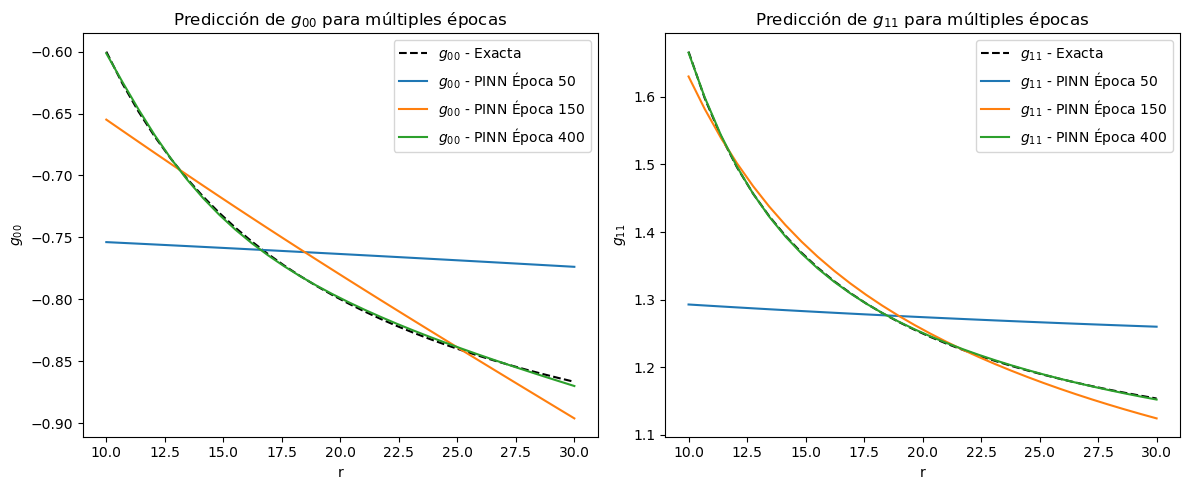

In [67]:
# Graficar las predicciones en las épocas seleccionadas
plot_predictions_multi(R, predictions_g_tt, predictions_g_rr, epochs_to_plot)


In [68]:
import numpy as np
from matplotlib.ticker import LogLocator, FuncFormatter

# Función para formatear las etiquetas del eje y
def log_format(exponent, pos):
    return f"{int(np.log10(exponent))}"  # Extraer el exponente como entero

# Ajustar las marcas y etiquetas del eje y

# Función para graficar la función de pérdida
def plot_loss(loss_history):
    custom_xticks = [0,100,200,300,400]
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Pérdida', lw=3, color='forestgreen')
    #plt.title('Evolución de la función de pérdida')
    plt.yscale('log')
    plt.xlabel('Época', fontsize=16)
    plt.ylabel('Pérdida', fontsize=16)
    plt.xticks(custom_xticks,fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))  # Marcas en potencias de 10
    plt.gca().yaxis.set_major_formatter(FuncFormatter(log_format))  # Formato del eje y
    #plt.legend(fontsize=18)
    plt.savefig('einsteinLoss.png')
    plt.show()
    


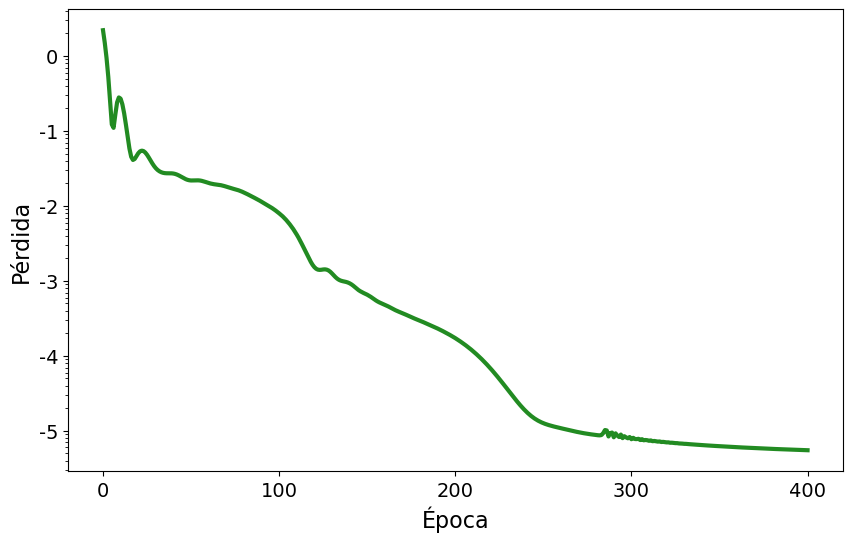

In [69]:
plot_loss(loss_history)


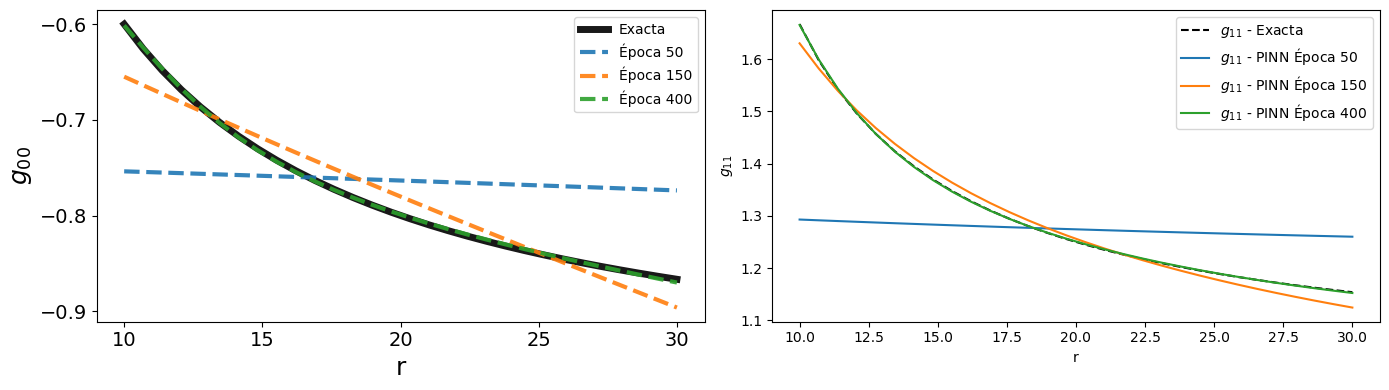

In [70]:
# Función para graficar las predicciones y las soluciones analíticas para múltiples épocas
def plot_predictions_multi(R, g_tt_preds, g_rr_preds, epochs):
    r_vals = R.detach().numpy()  # Convertir los valores de r a numpy

    # Soluciones analíticas
    g_tt_exact = -(1 - 2 * M / r_vals)  # Solución exacta de g_00
    g_rr_exact = 1 / (1 - 2 * M / r_vals)  # Solución exacta de g_11

    plt.figure(figsize=(14, 4))

    # Gráfico de g_tt
    plt.subplot(1, 2, 1)

    custom_xticks=[10,15,20,25,30]
    custom_yticks=[-0.6,-0.7,-0.8,-0.9]
    plt.plot(r_vals, g_tt_exact, label='Exacta', color='k', alpha=0.9, lw=5)#, linestyle='--')
    for g_tt_pred, epoch in zip(g_tt_preds, epochs):
        plt.plot(r_vals, g_tt_pred.detach().numpy(), lw=3, alpha=0.9,linestyle='--',label=f'Época {epoch}')
    #plt.title('Predicción de $g_{00}$ para múltiples épocas')
    plt.xlabel('r', fontsize =18)
    plt.ylabel('$g_{00}$', fontsize=18)
    plt.xticks(custom_xticks,fontsize=14)
    plt.yticks(custom_yticks,fontsize=14)
    plt.legend()
    plt.savefig('g00-ev-issste.png')

    # Gráfico de g_rr
    plt.subplot(1, 2, 2)
    plt.plot(r_vals, g_rr_exact, label='$g_{11}$ - Exacta', color='black', linestyle='--')
    for g_rr_pred, epoch in zip(g_rr_preds, epochs):
        plt.plot(r_vals, g_rr_pred.detach().numpy(), label=f'$g_{{11}}$ - PINN Época {epoch}')
    #plt.title('Predicción de $g_{11}$ para múltiples épocas')
    plt.xlabel('r')
    plt.ylabel('$g_{11}$')
    plt.legend()
    #plt.savefig('g11-ev-uni.png')

    # Mostrar las gráficas
    plt.tight_layout()
    
    plt.show()
    
plot_predictions_multi(R, predictions_g_tt, predictions_g_rr, epochs_to_plot)


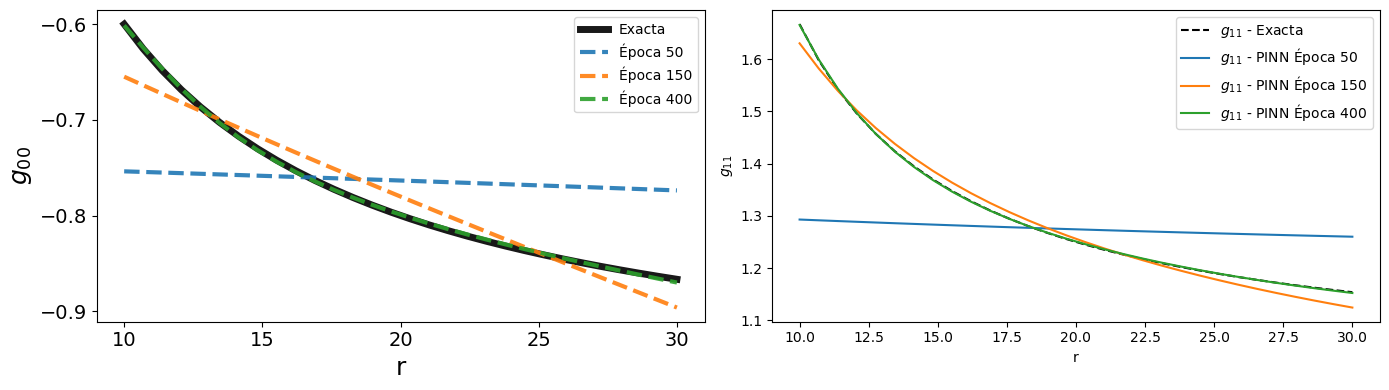

In [71]:
plot_predictions_multi(R, predictions_g_tt, predictions_g_rr, epochs_to_plot)


In [83]:
import matplotlib.pyplot as plt
import numpy as np
def plot_predictions_separate(R, g_tt_preds, g_rr_preds, epochs, 
                               colors=None, 
                               linestyles=None, 
                               custom_xticks_g00=None, 
                               custom_yticks_g00=None,
                               custom_xticks_g11=None, 
                               custom_yticks_g11=None,
                               figsize=(9, 6),
                               fontsize_labels=20,
                               fontsize_ticks=18):
    """
    Create separate plots for g_00 and g_11 with individual PNG saves
    
    Parameters are similar to previous function
    """
    # Convert R to numpy
    r_vals = R.detach().numpy()
    
    # Default parameters
    if colors is None:
        colors = ['forestgreen', 'mediumslateblue', 'coral']
    if linestyles is None:
        linestyles = ['--', '-.', ':']
    if custom_xticks_g00 is None:
        custom_xticks_g00 = [10, 15, 20, 25, 30]
    if custom_yticks_g00 is None:
        custom_yticks_g00 = [-0.6, -0.7, -0.8, -0.9]
    if custom_xticks_g11 is None:
        custom_xticks_g11 = [10, 15, 20, 25, 30]
    if custom_yticks_g11 is None:
        custom_yticks_g11 = [1.1,1.3,1.5,1.7]
    
    # Mass parameter (assuming it's defined globally or passed)
    M = 2.0  # Modify this if you have a different mass parameter
    
    # Compute exact solutions
    g_tt_exact = -(1 - 2 * M / r_vals)
    g_rr_exact = 1 / (1 - 2 * M / r_vals)
    
    # Plot g_00
    plt.figure(figsize=figsize)
    plt.plot(r_vals, g_tt_exact, label='Exacta', color='k', alpha=0.9, lw=6)
    
    # Plot predictions for g_00
    for i, (g_tt_pred, epoch) in enumerate(zip(g_tt_preds, epochs)):
        plt.plot(r_vals, g_tt_pred.detach().numpy(), 
                 color=colors[i % len(colors)], 
                 lw=5, 
                 alpha=0.9, 
                 linestyle=linestyles[i % len(linestyles)],
                 label=f'Época {epoch}')
    
    # Customize g_00 plot
    plt.xlabel('r', fontsize=fontsize_labels)
    plt.ylabel('$g_{tt}$', fontsize=fontsize_labels)
    plt.text(10.1, -0.875, r'(a)', fontsize=38, color='k')
    plt.xticks(custom_xticks_g00, fontsize=fontsize_ticks)
    plt.yticks(custom_yticks_g00, fontsize=fontsize_ticks)
    plt.legend(fontsize=18)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('g00_predictions.png')
    plt.close()  # Close the figure to free up memory
    
    # Plot g_11
    plt.figure(figsize=figsize)
    plt.plot(r_vals, g_rr_exact, label='Exacta', color='k', lw=6)
    
    # Plot predictions for g_11
    for i, (g_rr_pred, epoch) in enumerate(zip(g_rr_preds, epochs)):
        plt.plot(r_vals, g_rr_pred.detach().numpy(), 
                 color=colors[i % len(colors)], 
                 lw=5, 
                 alpha=0.9, 
                 label=f'Época {epoch}',
                 linestyle=linestyles[i % len(linestyles)])
    
    # Customize g_11 plot
    plt.xlabel('r', fontsize=fontsize_labels)
    plt.ylabel('$g_{rr}$', fontsize=fontsize_labels)
    plt.text(10.1, 1.15, r'(b)', fontsize=38, color='k')
    plt.xticks(custom_xticks_g11, fontsize=fontsize_ticks)
    plt.yticks(custom_yticks_g11, fontsize=fontsize_ticks)
    plt.legend(fontsize=18)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('g11_predictions.png')
    plt.close()  # Close the figure to free up memory

# Example usage
plot_predictions_separate(R, predictions_g_tt, predictions_g_rr, epochs_to_plot,
                           colors=[ 'mediumslateblue', 'forestgreen','coral'],
                           linestyles=['--', '-.', ':'])
plt.show()